In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import * 
from scipy.optimize import newton
from scipy.optimize import fsolve

In [20]:
def CIR(kappa, rbar, sig, r_tmin1):
    
    h1 = np.sqrt(kappa**2+2*sig**2)
    h2 = (kappa+h1)/2
    h3 = 2*kappa*rbar/sig**2
    B_T1T2 = (np.exp(h1*10)-1)/(h2*(np.exp(h1*10)-1)+h1)
    temp = h1*np.exp(h2*10)/(h2*(np.exp(h1*10)-1)+h1)
    A_T1T2 = np.power(temp, h3)
    r_tmin1_10 = -np.log(A_T1T2*np.exp(-B_T1T2*r_tmin1))/10
    
    return r_tmin1_10


CIR = np.vectorize(CIR)

In [21]:
def CPR_step_i(WAC, r_tmin1, PV_t_1,PV0, sig, kappa, rbar, SG_t, SY_t):
    r_tmin1_10 = CIR(kappa=kappa, rbar=rbar, sig=sig, r_tmin1=r_tmin1)
    RI_t = 0.28+0.14*np.arctan(-8.57+430*(WAC-r_tmin1_10))
    BU_t = 0.3 + 0.7*PV_t_1/PV0
    return RI_t*BU_t*SG_t*SY_t

In [22]:
def MBS_price(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12):
    dt = 1/120 #Set  the time interval to 1/120 year
    n = int(12 * T)
    M = 1000
    step = int(round(T / dt))
    rt = np.zeros((M, step + 1))
    rt[:, 0] = r0
    np.random.seed(713)
    for i in range(step):
        zt = np.random.normal(0, 1, M)
        rt[:, i + 1] = rt[:, i] + kappa * (rbar - rt[:, i]) * dt + sig * np.sqrt(np.abs(rt[:, i])) * np.sqrt(dt) * zt
    R = np.zeros((M, n))
    SY = np.zeros(n)
    PV = np.zeros((M, n))
    PV[:, 0] = L0
    ct = np.zeros((M, n))
    r = WAC/12
    for i in range(n):
        R[:, i] = np.sum(rt[:, 1:(10 * i + 11)], axis=1) * (-dt)
        r_tmin1_i = rt[:, 10 * i]
        SG_i= np.minimum(1, (i + 1) / 30)
        if i % 12 == 0:
            SY[i:(i + 12)] = np.array([0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98])
        CPR_i = CPR_step_i(WAC=WAC, r_tmin1=r_tmin1_i, PV_t_1=PV[:, i], PV0=L0, sig=sig, kappa=kappa, rbar=rbar, SG_t=SG_i, SY_t=SY[i])
        ct[:, i] = PV[:, i] * r / (1 - np.power(1 + r, i - n)) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                        1 - np.power((1 - CPR_i), 1 / 12))
        TPP_i = PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1) + (
                PV[:, i] - PV[:, i] * r * (1 / (1 - np.power(1 + r, i - n)) - 1)) * (
                         1 - np.power((1 - CPR_i), 1 / 12))
        if i < (n-1):
            PV[:, i + 1] = PV[:, i] - TPP_i
    disc = np.exp(R)
    MBS_price = np.mean(np.sum(np.multiply(disc, ct), axis=1))
    return MBS_price

In [23]:
MBS_price(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12)

100391.37873637977

In [25]:
MBS_price = np.vectorize(MBS_price)

q1a = MBS_price(T=30, L0=100000, WAC=0.08, r0=0.078, kappa=0.6, rbar=0.08, sig=0.12)
print("Given the input, the price of the MBS is : %.6f" % q1a)

Given the input, the price of the MBS is : 100391.378736


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


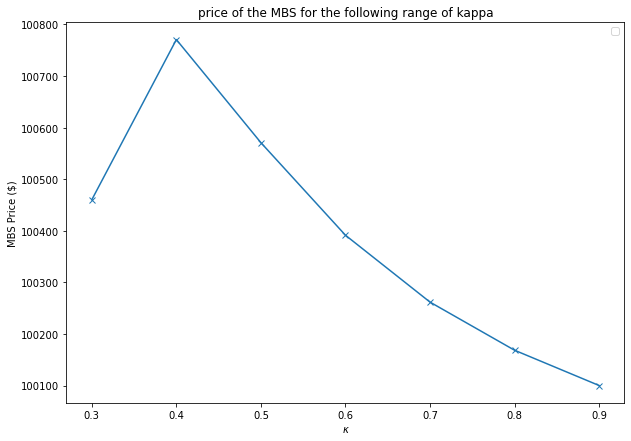

In [26]:
np.random.seed(9)
kappa_list = np.array([0.3 + 0.1*i for i in range(7)])
MBS_kappa = MBS_price(kappa=kappa_list)
plt.figure(figsize=(10,7))
plt.plot(kappa_list, MBS_kappa, marker='x', linestyle='-')
plt.title("price of the MBS for the following range of kappa")
plt.xlabel("$\kappa$")
plt.ylabel("MBS Price ($)")
plt.legend()
plt.show()